# Character RNNs: Generating Shakespearean Text

### Luis G.

Dataset : [Shakespear Dataset](https://homl.info/shakespeare) 

----------------------------

## 1. Preparation

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.1 Data Preparation

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

# Download Shakespeare's dataset
shakespeare_url = "https://homl.info/shakespeare"
file_name = "shakespeare.txt"
filepath = keras.utils.get_file(file_name, shakespeare_url)

# Read/Store text file in string
with open(filepath) as f:
    shakespeare_text = f.read()

# Print a small section of the dataset
print(shakespeare_text[:148])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?



### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.2 Text/Word Pre-processing

In [2]:
# Tokenize - encode each CHARACTER as an integer/id
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

# Number of distinct characters
max_id = len(tokenizer.word_index)
print("Distinct Characters:", max_id)

# Total number of characters
dataset_size = tokenizer.document_count
print("Dataset (characters) size:", dataset_size)

# Verify tokenizer -> ex: word - "First"
seq_to_txt = tokenizer.texts_to_sequences(["First"])
txt_to_seq = tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])
print("\nSequence to text:", seq_to_txt)
print("Text to sequence:", txt_to_seq)

Distinct Characters: 39
Dataset (characters) size: 1115394

Sequence to text: [[20, 6, 9, 8, 3]]
Text to sequence: ['f i r s t']


In [3]:
# Encode the entire dataset so each char is represented by it's unique ID
# - Subtract by 1, to get vals 0-38 vs. 1-39
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.3 Creating Training & Testing Data

In [4]:
# Training set = 90%
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

2023-11-12 03:33:45.095851: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-12 03:33:45.110823: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-12 03:33:45.110943: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-12 03:33:45.112041: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [5]:
# (Pre) Window length
n_steps = 100

# target = input shifted 1 character ahead
window_length = n_steps + 1
dataset = dataset.window(window_length, shift=1,drop_remainder=True)

# Store 3 elements for the (nested) dataset (see below)
preview_nested = dataset.take(3)

In [6]:
# Convert nested dataset to flat dataset (doesn't contain datasets)
dataset = dataset.flat_map(lambda window: window.batch(window_length))

# Store 3 elements for the (flat) dataset (see below)
preview_flat = dataset.take(3)

In [7]:
print("================================== [Before] Nested Dataset ==================================")
for window in preview_nested:
    print(list(window.as_numpy_iterator()))
    
print("\n================================== [After] Flattening Dataset ==================================")
list(preview_flat.as_numpy_iterator())

================================== [Before] Nested Dataset ==================================
[19, 5, 8, 7, 2, 0, 18, 5, 2, 5, 35, 1, 9, 23, 10, 21, 1, 19, 3, 8, 1, 0, 16, 1, 0, 22, 8, 3, 18, 1, 1, 12, 0, 4, 9, 15, 0, 19, 13, 8, 2, 6, 1, 8, 17, 0, 6, 1, 4, 8, 0, 14, 1, 0, 7, 22, 1, 4, 24, 26, 10, 10, 4, 11, 11, 23, 10, 7, 22, 1, 4, 24, 17, 0, 7, 22, 1, 4, 24, 26, 10, 10, 19, 5, 8, 7, 2, 0, 18, 5, 2, 5, 35, 1, 9, 23, 10, 15, 3, 13, 0]
[5, 8, 7, 2, 0, 18, 5, 2, 5, 35, 1, 9, 23, 10, 21, 1, 19, 3, 8, 1, 0, 16, 1, 0, 22, 8, 3, 18, 1, 1, 12, 0, 4, 9, 15, 0, 19, 13, 8, 2, 6, 1, 8, 17, 0, 6, 1, 4, 8, 0, 14, 1, 0, 7, 22, 1, 4, 24, 26, 10, 10, 4, 11, 11, 23, 10, 7, 22, 1, 4, 24, 17, 0, 7, 22, 1, 4, 24, 26, 10, 10, 19, 5, 8, 7, 2, 0, 18, 5, 2, 5, 35, 1, 9, 23, 10, 15, 3, 13, 0, 4]
[8, 7, 2, 0, 18, 5, 2, 5, 35, 1, 9, 23, 10, 21, 1, 19, 3, 8, 1, 0, 16, 1, 0, 22, 8, 3, 18, 1, 1, 12, 0, 4, 9, 15, 0, 19, 13, 8, 2, 6, 1, 8, 17, 0, 6, 1, 4, 8, 0, 14, 1, 0, 7, 22, 1, 4, 24, 26, 10, 10, 4, 11, 11, 23, 10,

2023-11-12 03:33:45.676262: W tensorflow/core/framework/dataset.cc:768] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


[array([19,  5,  8,  7,  2,  0, 18,  5,  2,  5, 35,  1,  9, 23, 10, 21,  1,
        19,  3,  8,  1,  0, 16,  1,  0, 22,  8,  3, 18,  1,  1, 12,  0,  4,
         9, 15,  0, 19, 13,  8,  2,  6,  1,  8, 17,  0,  6,  1,  4,  8,  0,
        14,  1,  0,  7, 22,  1,  4, 24, 26, 10, 10,  4, 11, 11, 23, 10,  7,
        22,  1,  4, 24, 17,  0,  7, 22,  1,  4, 24, 26, 10, 10, 19,  5,  8,
         7,  2,  0, 18,  5,  2,  5, 35,  1,  9, 23, 10, 15,  3, 13,  0]),
 array([ 5,  8,  7,  2,  0, 18,  5,  2,  5, 35,  1,  9, 23, 10, 21,  1, 19,
         3,  8,  1,  0, 16,  1,  0, 22,  8,  3, 18,  1,  1, 12,  0,  4,  9,
        15,  0, 19, 13,  8,  2,  6,  1,  8, 17,  0,  6,  1,  4,  8,  0, 14,
         1,  0,  7, 22,  1,  4, 24, 26, 10, 10,  4, 11, 11, 23, 10,  7, 22,
         1,  4, 24, 17,  0,  7, 22,  1,  4, 24, 26, 10, 10, 19,  5,  8,  7,
         2,  0, 18,  5,  2,  5, 35,  1,  9, 23, 10, 15,  3, 13,  0,  4]),
 array([ 8,  7,  2,  0, 18,  5,  2,  5, 35,  1,  9, 23, 10, 21,  1, 19,  3,
         8,  1, 

In [8]:
#np.random.seed(42)
#tf.random.set_seed(42)

batch_size = 64
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

---------------------

Here is a quick breakdown/demo on what just happened:

In [9]:
preview_dataset = preview_flat.shuffle(10000).batch(batch_size)
print("================================== Preview dataset post shuffle + batch ==================================")
print(list(preview_dataset.as_numpy_iterator()))

preview_dataset = preview_dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
print("\n================================== Preview dataset post map ==================================")
list(preview_dataset.as_numpy_iterator())

================================== Preview dataset post shuffle + batch ==================================
[array([[ 8,  7,  2,  0, 18,  5,  2,  5, 35,  1,  9, 23, 10, 21,  1, 19,
         3,  8,  1,  0, 16,  1,  0, 22,  8,  3, 18,  1,  1, 12,  0,  4,
         9, 15,  0, 19, 13,  8,  2,  6,  1,  8, 17,  0,  6,  1,  4,  8,
         0, 14,  1,  0,  7, 22,  1,  4, 24, 26, 10, 10,  4, 11, 11, 23,
        10,  7, 22,  1,  4, 24, 17,  0,  7, 22,  1,  4, 24, 26, 10, 10,
        19,  5,  8,  7,  2,  0, 18,  5,  2,  5, 35,  1,  9, 23, 10, 15,
         3, 13,  0,  4,  8],
       [ 5,  8,  7,  2,  0, 18,  5,  2,  5, 35,  1,  9, 23, 10, 21,  1,
        19,  3,  8,  1,  0, 16,  1,  0, 22,  8,  3, 18,  1,  1, 12,  0,
         4,  9, 15,  0, 19, 13,  8,  2,  6,  1,  8, 17,  0,  6,  1,  4,
         8,  0, 14,  1,  0,  7, 22,  1,  4, 24, 26, 10, 10,  4, 11, 11,
        23, 10,  7, 22,  1,  4, 24, 17,  0,  7, 22,  1,  4, 24, 26, 10,
        10, 19,  5,  8,  7,  2,  0, 18,  5,  2,  5, 35,  1,  9, 23, 10,

[(array([[ 8,  7,  2,  0, 18,  5,  2,  5, 35,  1,  9, 23, 10, 21,  1, 19,
           3,  8,  1,  0, 16,  1,  0, 22,  8,  3, 18,  1,  1, 12,  0,  4,
           9, 15,  0, 19, 13,  8,  2,  6,  1,  8, 17,  0,  6,  1,  4,  8,
           0, 14,  1,  0,  7, 22,  1,  4, 24, 26, 10, 10,  4, 11, 11, 23,
          10,  7, 22,  1,  4, 24, 17,  0,  7, 22,  1,  4, 24, 26, 10, 10,
          19,  5,  8,  7,  2,  0, 18,  5,  2,  5, 35,  1,  9, 23, 10, 15,
           3, 13,  0,  4],
         [ 5,  8,  7,  2,  0, 18,  5,  2,  5, 35,  1,  9, 23, 10, 21,  1,
          19,  3,  8,  1,  0, 16,  1,  0, 22,  8,  3, 18,  1,  1, 12,  0,
           4,  9, 15,  0, 19, 13,  8,  2,  6,  1,  8, 17,  0,  6,  1,  4,
           8,  0, 14,  1,  0,  7, 22,  1,  4, 24, 26, 10, 10,  4, 11, 11,
          23, 10,  7, 22,  1,  4, 24, 17,  0,  7, 22,  1,  4, 24, 26, 10,
          10, 19,  5,  8,  7,  2,  0, 18,  5,  2,  5, 35,  1,  9, 23, 10,
          15,  3, 13,  0],
         [19,  5,  8,  7,  2,  0, 18,  5,  2,  5, 35,  1, 

Here are some [definitions](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) that may further help:
* `shuffle()`: Randomly shuffles the elements of this dataset.
* `batch()`: Combines consecutive elements of this dataset into batches.
* `map()`: This transformation applies `map_func` to each element of this dataset, and returns a new dataset containing the transformed elements, in the same order as they appeared in the input.

--------------------

In [10]:
# Encode each char using one-hot vector since there's only 39 distinct characters
dataset = dataset.map(lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))

# Add prefetching to dataset
dataset = dataset.prefetch(1)

-----------------------------

## 2. Modeling

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2.1 Exploring Recurrent Network Architectures: GRU

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, TimeDistributed, Dense

model = Sequential()
model.add(GRU(128, return_sequences=True, input_shape=[None,max_id], dropout=0.2))
model.add(GRU(128, return_sequences=True, dropout=0.2))
model.add(TimeDistributed(Dense(max_id, activation="softmax")))

#model = Sequential([
#            GRU(128, return_sequences=True, input_shape=[None,max_id], dropout=0.2),
#            GRU(128, return_sequences=True, dropout=0.2),
#            TimeDistributed(Dense(max_id, activation="softmax"))
#        ])

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset,epochs=20)

Epoch 1/20


2023-11-12 03:33:48.495366: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


      9/Unknown - 3s 7ms/step - loss: 3.5680

2023-11-12 03:33:49.089395: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


15684/15684 [==============================] - 111s 7ms/step - loss: 1.6791
Epoch 2/20
15684/15684 [==============================] - 110s 7ms/step - loss: 1.5757
Epoch 3/20
15684/15684 [==============================] - 110s 7ms/step - loss: 1.5500
Epoch 4/20
15684/15684 [==============================] - 108s 7ms/step - loss: 1.5372
Epoch 5/20
15684/15684 [==============================] - 110s 7ms/step - loss: 1.5291
Epoch 6/20
15684/15684 [==============================] - 113s 7ms/step - loss: 1.5236
Epoch 7/20
15684/15684 [==============================] - 115s 7ms/step - loss: 1.5195
Epoch 8/20
15684/15684 [==============================] - 117s 7ms/step - loss: 1.5160
Epoch 9/20
15684/15684 [==============================] - 110s 7ms/step - loss: 1.5134
Epoch 10/20
15684/15684 [==============================] - 107s 7ms/step - loss: 1.5110
Epoch 11/20
15684/15684 [==============================] - 109s 7ms/step - loss: 1.5089
Epoch 12/20
15684/15684 [===========================

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, None, 128)         64896     
                                                                 
 gru_1 (GRU)                 (None, None, 128)         99072     
                                                                 
 time_distributed (TimeDistr  (None, None, 39)         5031      
 ibuted)                                                         
                                                                 
Total params: 168,999
Trainable params: 168,999
Non-trainable params: 0
_________________________________________________________________


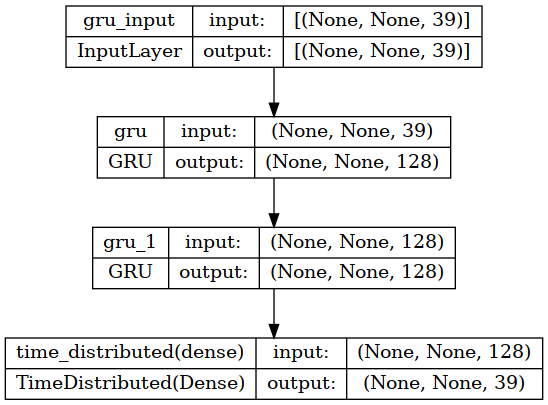

In [13]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True,)

In [14]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, max_id)

In [15]:
X_new = preprocess(["How are yo"])
Y_pred = np.argmax(model(X_new), axis=-1)

# 1st sentence, last character
tokenizer.sequences_to_texts(Y_pred + 1)[0][-1]

'u'